In [6]:
import os
import sys
import random
import pandas as pd
import numpy as np
from os.path import join
from tqdm import tqdm
sys.path.append('../include')

from utils import process_annotation, parse_remark_cell, get_labels_start_end_time
from visualize import get_labels, plot_action_list

#### CHANGE START INDEX WHEN WORKING WITH DIFFERENT DATASET FORMATS ####

## Step 0: Set up the directories and variables
- general setup and variable initalization
- remove videos with complicaitons from list

In [28]:

base_dir = "/home/simon/Data/2024_SICS_SMARTPHONE"
video_dir = join(base_dir, "videos_hd")
gt_dir = join(base_dir, 'groundTruth_c20_nobg')
annotations = pd.read_csv(join(base_dir, "SICS_smartphone_annotations.csv"))
col_id = "Video_ID"
col_files = "OLD_FILE"
FPS = 15
data_start_col = 2
remarks_start_idx = 42

if not os.path.exists(gt_dir):
    os.mkdir(gt_dir)

print(f"Found {len(os.listdir(video_dir))} videos in {os.path.basename(video_dir)}")
print(f"Found {len(annotations)} annotations in <annotation>.csv")

Found 73 videos in videos_hd
Found 72 annotations in <annotation>.csv


In [16]:
## remove videos with complications e.g. vitreoectomy
exclude_videos = []# ["Difficult cataract 1", "Difficult cataract 2", "Video 15", "Video 37", "Video 38", "video 40", "video 42", "video 43", "video 44", "video 45", "Video 47", "Video 48", "video 51", "video 66"]

print(f"Number of videos with complications to be excluded: {len(exclude_videos)}")
#annotations = annotations[~annotations['OLD_ID'].isin(exclude_videos)] # Drop rows with excluded videos

# Drop rows with column value higher than outlier_length of x minutes
outlier_length = 21.5
#annotations["Duration_surgery"] = annotations["Duration_surgery"].apply(lambda d: int(d.split(":")[0]))
#print(f"Number of videos that are too long to be excluded: ", len(annotations[annotations['Duration_surgery'] > outlier_length].index))
#annotations = annotations.drop(annotations[annotations['Duration_surgery'] > outlier_length].index)

if col_files not in annotations.columns:
    annotations[col_files] = annotations[col_id].apply(lambda x: f"{x.split(' ')[1]}.mp4")

# check if each row correspondence to a video file in the video directory
for i, row in annotations.iterrows():
    video_file = row[col_files]
    if pd.isna(video_file):
        continue
    video_path = join(video_dir, video_file)
    if not os.path.exists(video_path):
        print(f"Missing video: {video_path}")
        continue

print(f"After exclusion, {len(annotations)} annotations are left")

Number of videos with complications to be excluded: 0
After exclusion, 72 annotations are left


## Step 1: Write class mapping for each annotation phase to file mapping.txt

In [17]:

def generate_mapping(dataframe, start_idx=7):
    mapping = {"background": 0}
    mapping_count = 1
    for col_name in dataframe.columns[start_idx:start_idx+40]:
        #print(f'Class: {col_name}')
        class_name = "_".join(col_name.split('_')[:-1])
        if mapping.get(class_name) is None:
            mapping[class_name] = mapping_count
            mapping_count += 1
    return mapping
        
mapping = generate_mapping(annotations, start_idx=2)
with open(join(base_dir, 'mapping.txt'), 'w') as f:
    for key, value in mapping.items():
        f.write(f'{value} {key}\n')

print("Generated mapping: ", mapping)

Generated mapping:  {'background': 0, 'SR_bridle_suture': 1, 'peritomy': 2, 'cautery': 3, 'scleral_groove': 4, 'incision': 5, 'tunnel': 6, 'sideport': 7, 'AB_injection_and_wash': 8, 'OVD_injection': 9, 'capsulorrhexis': 10, 'capsulorrhexix': 11, 'main_incision_entry': 12, 'hydroprocedure': 13, 'nucleus_prolapse': 14, 'nucleus_delivery': 15, 'cortical_wash': 16, 'OVD_IOL_insertion': 17, 'OVD_wash': 18, 'stromal_hydration': 19, 'tunnel_suture': 20, 'conjunctival_cautery': 21, 'conjunvtival_cautery': 22}


## Step 2: Generate frame-wise annotations for each video and write them to file 

In [21]:
print(f'####### Processing {len(annotations)} annotations #######')
bg_perc = []
for i, row in annotations.iterrows():
    print(f"Working on {row[col_files]}...")
    cur_annotation = process_annotation(row, video_dir, mapping, col_name=col_files, fps=FPS, start_idx=data_start_col)
    #print(len(anno), np.count_nonzero(anno))
    #print(anno[500:1000])
    
    # sanity check
    class_dict = dict(zip(*np.unique(cur_annotation, return_counts=True)))
    inv_class = {v: k for k, v in mapping.items()}
    class_occurence = {inv_class[k]: v/30.0 for k, v in class_dict.items()}
    background_count, total_count = class_occurence["background"], sum(class_occurence.values())
    bg_perc.append(background_count / total_count)
    # print(f'Percentage of background: {background_count / total_count}, {class_occurence}')
    
    #convert and write to file
    anno_list = [inv_class[elm] for elm in cur_annotation.tolist()]
    with open(join(gt_dir, f'{os.path.splitext(row[col_id])[0]}.txt'), 'w') as f:
        f.write("\n".join(anno_list))
        pass
    
print(f'Average background percentage: {np.mean(bg_perc)}')
print(f'Wrote annotations to {gt_dir}')

####### Processing 72 annotations #######
Working on 10.mp4...
Working on 110.mp4...
Working on 111.mp4...


[h264 @ 0x562608ca3880] too many reference frames 30
[h264 @ 0x562608ca3880] too many reference frames 30
[h264 @ 0x562608ca3880] too many reference frames 30
[h264 @ 0x562608ca3880] too many reference frames 30
[h264 @ 0x562608ca3880] crop values invalid 1 10 5 0 / 16 64
[h264 @ 0x562608ca3880] sps_id 1 out of range
[h264 @ 0x562608ca3880] crop values invalid 1 10 5 0 / 16 64
[h264 @ 0x562608ca3880] crop values invalid 1 10 5 0 / 16 64
[h264 @ 0x562608ca3880] crop values invalid 1 10 5 0 / 16 64
[h264 @ 0x562608ca3880] sps_id 1 out of range


Working on 13.mp4...
Working on 14.mp4...
Working on 15.mp4...
Working on 16.mp4...


[h264 @ 0x562608ca3880] too many reference frames 30
[h264 @ 0x562608ca3880] too many reference frames 30
[h264 @ 0x562608ca3880] too many reference frames 30
[h264 @ 0x562608ca3880] too many reference frames 30


Working on 17.mp4...
Working on 18.mp4...
Working on 19.mp4...
Working on 20.mp4...
Working on 21.mp4...
Working on 23.mp4...
Working on 25.mp4...
Working on 26.mp4...
Working on 27.mp4...
Working on 36.mp4...
Working on 37.mp4...
Working on 38.mp4...
Working on 39.mp4...
Working on 42.mp4...
Working on 44.mp4...
Working on 45.mp4...
Working on 46.mp4...
Working on 47.mp4...
Working on 48.mp4...
Working on 49.mp4...
Working on 50.mp4...
Working on 51.mp4...
Working on 52.mp4...
Working on 53.mp4...
Working on 54.mp4...
Working on 55.mp4...
Working on 58.mp4...
Working on 59.mp4...
Working on 6.mp4...
Working on 60.mp4...
Working on 61.mp4...
Working on 62.mp4...
Working on 63.mp4...
Working on 64.mp4...
Working on 65.mp4...
Working on 66.mp4...
Working on 67.mp4...
Working on 68.mp4...
Working on 69.mp4...
Working on 7.mp4...
Working on 70.mp4...
Working on 71.mp4...
Working on 72.mp4...
Working on 73.mp4...
Working on 74.mp4...
Working on 75.mp4...
Working on 76.mp4...
Working on 77.m

[h264 @ 0x562608409d00] illegal POC type 14
[h264 @ 0x562608409d00] illegal POC type 14
[h264 @ 0x562608409d00] illegal POC type 14
[h264 @ 0x562608409d00] illegal POC type 14
[h264 @ 0x562608ca3880] illegal POC type 14
[h264 @ 0x562608ca3880] illegal POC type 14
[h264 @ 0x562608ca3880] illegal POC type 14
[h264 @ 0x562608ca3880] illegal POC type 14
[h264 @ 0x562608ca3880] too many reference frames 32
[h264 @ 0x562608ca3880] sps_id 2 out of range
[h264 @ 0x562608ca3880] too many reference frames 32
[h264 @ 0x562608ca3880] too many reference frames 32
[h264 @ 0x562608ca3880] too many reference frames 32
[h264 @ 0x562608ca3880] sps_id 2 out of range


Working on 9.mp4...
Working on 90.mp4...
Working on 91.mp4...


[h264 @ 0x562608ca3880] error while decoding MB 95 2, bytestream -13
[h264 @ 0x562608ca3880] too many reference frames 32
[h264 @ 0x562608ca3880] sps_id 2 out of range
[h264 @ 0x562608ca3880] too many reference frames 32
[h264 @ 0x562608ca3880] too many reference frames 32
[h264 @ 0x562608ca3880] too many reference frames 32
[h264 @ 0x562608ca3880] sps_id 2 out of range
[h264 @ 0x562608ca3880] too many reference frames 32
[h264 @ 0x562608ca3880] sps_id 2 out of range
[h264 @ 0x562608ca3880] too many reference frames 32
[h264 @ 0x562608ca3880] too many reference frames 32
[h264 @ 0x562608ca3880] too many reference frames 32
[h264 @ 0x562608ca3880] sps_id 2 out of range


Working on 92.mp4...
Working on 93.mp4...
Working on 94.mp4...


[h264 @ 0x562608ca3880] error while decoding MB 88 1, bytestream -10
[h264 @ 0x562608ca3880] missing picture in access unit with size 5958
[h264 @ 0x562608ca3880] no frame!
[h264 @ 0x562608ca3880] A non-intra slice in an IDR NAL unit.
[h264 @ 0x562608ca3880] decode_slice_header error
[h264 @ 0x562608ca3880] no frame!
[h264 @ 0x562608ca3880] SEI type 25 size 144 truncated at 63
[h264 @ 0x562608ca3880] SEI type 211 size 194 truncated at 17
[h264 @ 0x562608ca3880] non-existing PPS 6 referenced
[h264 @ 0x562608ca3880] no frame!
[h264 @ 0x562608ca3880] missing picture in access unit with size 1231
[h264 @ 0x562608ca3880] no frame!
[h264 @ 0x562608ca3880] left block unavailable for requested intra4x4 mode -1
[h264 @ 0x562608ca3880] error while decoding MB 0 0, bytestream 1181
[h264 @ 0x562608ca3880] number of reference frames (0+2) exceeds max (1; probably corrupt input), discarding one
[h264 @ 0x562608ca3880] missing picture in access unit with size 7146
[h264 @ 0x562608ca3880] no frame!
[h

Working on 95.mp4...
Average background percentage: 0.47803315485654685
Wrote annotations to /home/simon/Data/2024_SICS_SMARTPHONE/groundTruth_c20_nobg


[h264 @ 0x562608ca3880] sps_id 19 out of range
[h264 @ 0x562608ca3880] sps_id 19 out of range


## Step 3: Incoperate additional (structured) remarks into ground truth files

In [26]:

for i, row in annotations.iterrows():
    print('Working on remarks for video: ', row.iloc[0])
    video_id = row.iloc[0]
    
    gt_file = row[col_id] + '.txt'
    if not gt_file or not os.path.exists(join(gt_dir, gt_file)):
        print(f'Ground truth file {gt_file} not found')
        continue
    
    gt_lines = open(join(gt_dir, gt_file), 'r').readlines()
    # if gt_lines[-1] == '': gt_lines = gt_lines[:-1]
    
    for i in range(remarks_start_idx, len(row)-1, 2):
        # print(row.iloc[i], row.iloc[i+1])
        if pd.isna(row.iloc[i]) or pd.isna(row.iloc[i+1]):
            continue
        start, end, cur_class = parse_remark_cell(row.iloc[i], row.iloc[i+1], mapping, fps=FPS)
        if start is None or end is None or cur_class is None:
            continue
        print('Parsed remark: ', start, end, cur_class)
        
        for i in range(start, end):
            gt_lines[i] = cur_class + '\n'
    open(join(gt_dir, gt_file), 'w').writelines(gt_lines)     

Working on remarks for video:  Video 10
Parsed remark:  4965 6765 capsulorrhexis
Working on remarks for video:  Video 110
Working on remarks for video:  Video 111
Parsed remark:  11655 11730 sideport
Parsed remark:  14565 14670 OVD_IOL_insertion
Parsed remark:  15075 15225 OVD_IOL_insertion
Parsed remark:  15255 15840 OVD_wash
Working on remarks for video:  Video 13
Parsed remark:  18840 19410 OVD_IOL_insertion
Parsed remark:  19560 20100 cortical_wash
Working on remarks for video:  Video 14
Working on remarks for video:  Video 15
Working on remarks for video:  video 16
Working on remarks for video:  video 17
Working on remarks for video:  video 18
Working on remarks for video:  video 19
Working on remarks for video:  video 20
Working on remarks for video:  video 21
Working on remarks for video:  video 23
Working on remarks for video:  video 25
Parsed remark:  11955 12030 sideport
Working on remarks for video:  Video 26
Working on remarks for video:  Video 27
Working on remarks for vid

## Step 4: Combine certain classes into one class and merge if possible

In [27]:

def reduce_classes_in_gt(actions, combinations, bg='background'):
    flag_combine = False
    start_idx = -1
    last_class = None
    end_idx = -1
    inside_anno = False
    
    # Combine certain actions
    for comb in combinations:
        actions = [comb[0] if action in comb else action for action in actions]

    # Combine actions that are the same and are next to each other
    for idx, action in enumerate(actions):
        cur_class = actions[idx]
        
        if not inside_anno and cur_class != 'background' and cur_class != last_class:
            inside_anno = True
            start_idx = idx
            continue
        elif not inside_anno and cur_class != 'background' and last_class == cur_class:
            inside_anno = True
            flag_combine = True
            continue
        
        if inside_anno and cur_class == 'background' and not flag_combine:
            inside_anno = False
            end_idx = idx - 1
            last_class = actions[end_idx]
        elif inside_anno and cur_class == 'background' and flag_combine:
            flag_combine = False
            inside_anno = False
            end_idx = idx - 1
            last_class = actions[end_idx]
            for i in range(start_idx, end_idx+1):
                actions[i] = last_class
    return actions

combinations = [                                                    
                #['cautery', 'peritomy'], # cm --> yes 
                #['scleral_groove', 'incision', 'tunnel'] # cm --> yes,
                #['hydroprocedure', 'nucleus_prolapse', 'nucleus_delivery'],
                #['stromal_hydration', 'tunnel_suture', 'conjunctival_cautery'], # cm --> yes 
                ['tunnel_suture', 'conjunctival_cautery'],
                ['scleral_groove', 'incision'],
                ['background', 'SR_bridle_suture'] # remove SR_bridle_suture due to low occurence
            ]     
labels = get_labels('sics73')

gt_files = os.listdir(gt_dir)
for file in tqdm(gt_files):
    cur_gt = open(join(gt_dir, file), 'r').read().split('\n')
    gt = reduce_classes_in_gt(cur_gt, combinations, bg='background')
    open(join(gt_dir, file), 'w').write("\n".join(gt))

print(f'Wrote annotations with combinded classes to {gt_dir}')

100%|██████████| 72/72 [00:00<00:00, 193.49it/s]

Wrote annotations with combinded classes to /home/simon/Data/2024_SICS_SMARTPHONE/groundTruth_c20_nobg


## Step 5 (optional): Remove background inbetween clases
- Extend current class until the beginning of the next class
- Ablation study whether background impacts algorithm performance

In [16]:
def remove_intraclass_bg(actions, idx_end=-1, bg='background'):
    last_action = None 
    for i, action in enumerate(actions):
        if i >= idx_end: # skip last section
            continue
        if last_action == None and action != bg:
            last_action = action
        elif action == bg and last_action != None:
            actions[i] = last_action
        elif action != last_action and action != bg:
            last_action = action
    return actions

gt_files = os.listdir(gt_dir)
for file in tqdm(gt_files):
    cur_gt = open(join(gt_dir, file), 'r').read().split('\n') # Read file
    
    _, start, _ = get_labels_start_end_time(cur_gt)
    cur_gt = remove_intraclass_bg(cur_gt, idx_end=start[-1], bg='background') 
    
    open(join(gt_dir, file), 'w').write("\n".join(cur_gt)) # Write changed file

print(f'Wrote annotations with removed intra-class background to {gt_dir}')

100%|██████████| 40/40 [00:00<00:00, 297.17it/s]

Wrote annotations with removed intra-class background to /home/simon/Data/sics_micro_data/groundTruth_micro_c20_nobg


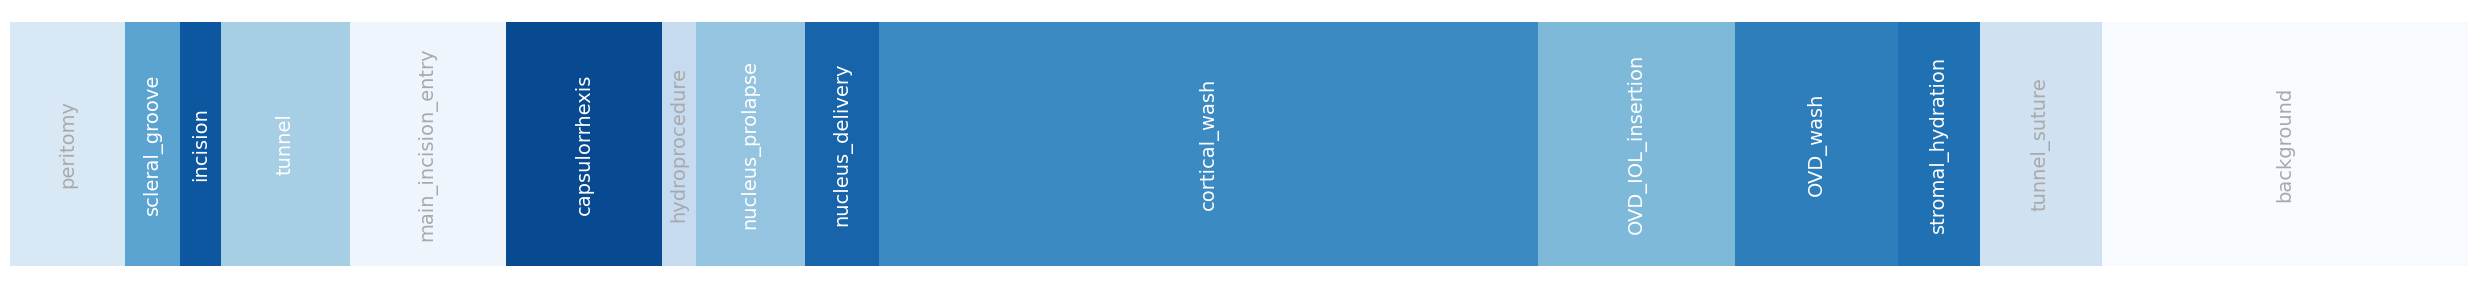

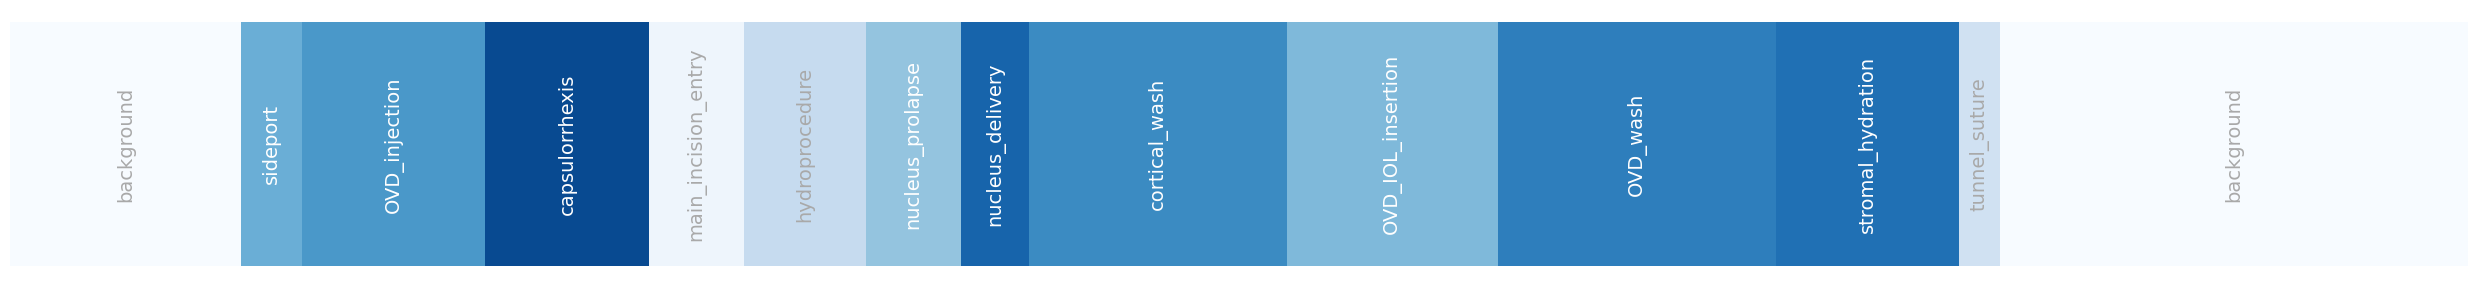

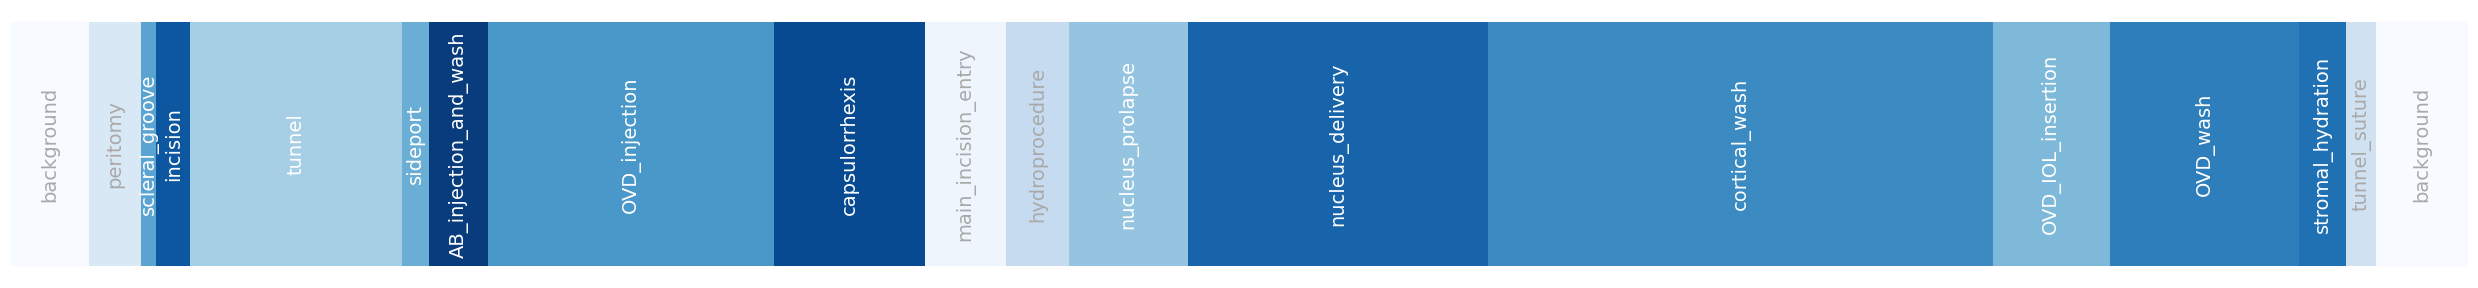

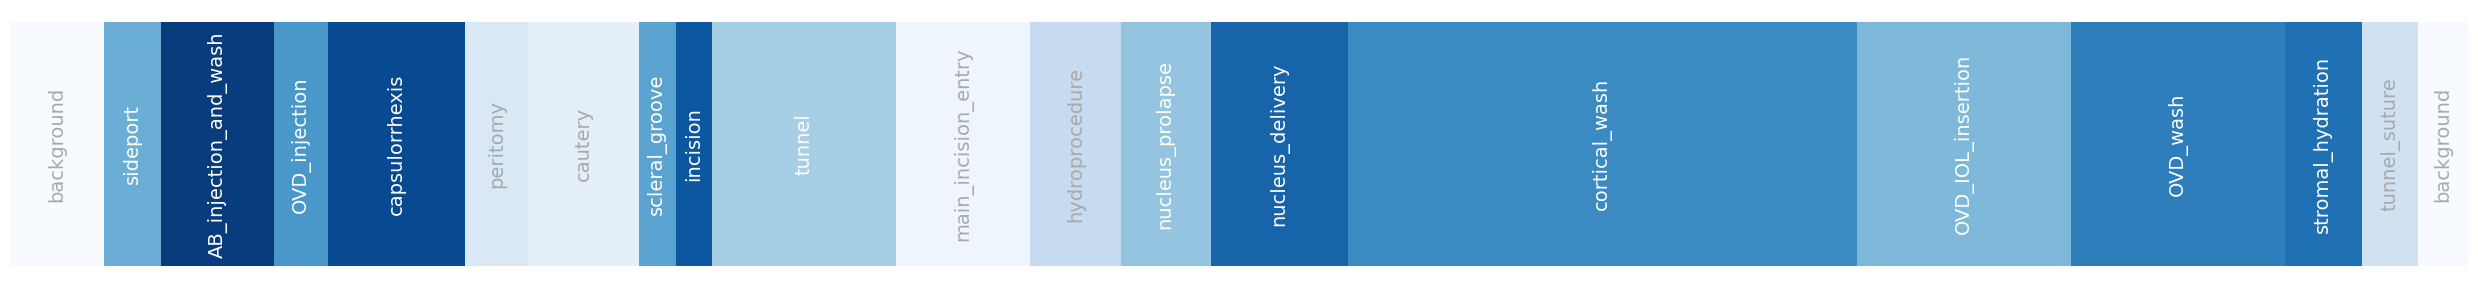

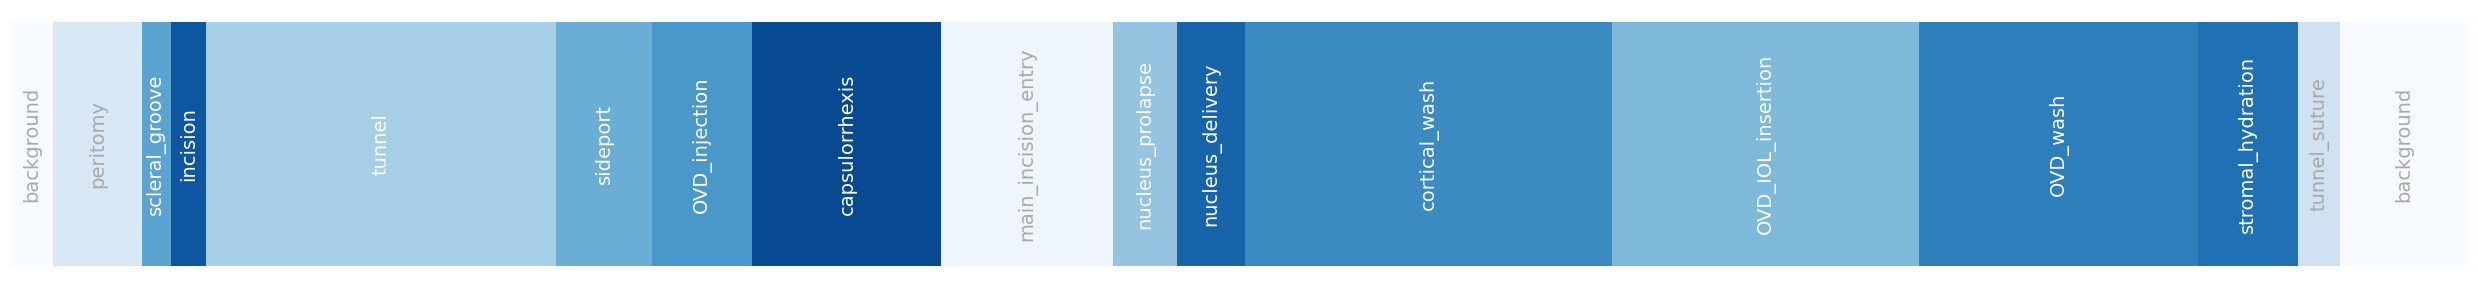

In [10]:
import random
labels = get_labels('sics73')
# Plot the first 5 ground truth files
for file in random.sample(gt_files, 5): 
    cur_gt = open(join(gt_dir, file), 'r').read().split('\n')
    #print(list(set(cur_gt)), cur_gt[-1])
    #print(cur_gt[-10:])
    plot_action_list(cur_gt, labels)

In [16]:
# Sanity check on extracted groud truth

gt_files = os.listdir(gt_dir)
selected_files = random.sample(gt_files, 5) # Randomly select 10 files
perform_check = False

for file in selected_files: # Iterate over the selected files
    if not perform_check: break
    
    print(f"Sanity check on gt file: {file}")
    with open(join(gt_dir, file), 'r') as f:
        lines = f.readlines()
        selected_lines = random.sample(list(enumerate(lines)), 10) # Randomly select 10 lines with line numbers
        for line_number, line in selected_lines: # Print the selected lines with line numbers
            print(f"Timestamp: {int((line_number + 1) / FPS)}sec - {int((line_number + 1) / FPS // 60)}:{int((line_number + 1) / FPS % 60):02d}, class {line.strip()}")
    print()


In [ ]:
# Include bhuvans wild data.
base_dir = "/home/simon/Data/sics_micro_data"
video_dir = '/home/simon/Data/sics_micro_ds/'
gt_dir = join(base_dir, 'groundTruth_micro_c20_nobg')
if not os.path.exists(gt_dir):
    os.mkdir(gt_dir)
annotations = pd.read_csv('/home/simon/Data/sics_micro_data/annos.csv')
annotations = annotations.drop(columns=['remarks', 'Unnamed: 1', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52'])
annotations = annotations.rename(columns={'Video ID': 'Video_ID'})
annotations["OLD_FILE"] = annotations["Video_ID"].apply(lambda x: x + ".mp4")
cols = ['OLD_FILE'] + [col for col in annotations.columns if col != 'OLD_FILE']
annotations = annotations.reindex(columns=cols)
files = os.listdir(video_dir)

col_id = "Video_ID"
col_files = "OLD_FILE"
FPS = 15

to_delete = []
for i, row in annotations.iterrows():
    video_file = row[col_files]
    if video_file not in files:
        to_delete.append(i)
annotations = annotations.drop(to_delete)
annotations.head()